# Control Flow Operator

## Switch

```python
def switch(index, branches, *operands):
  index = clamp(0, index, len(branches) - 1)
  return branches[index](*operands)
```

In [1]:
from jax import random
from jax.lax import switch
from jax import numpy as jnp

In [2]:
random.randint(random.PRNGKey(0), shape=(), minval=0, maxval=10)

Array(2, dtype=int32)

In [3]:
rand_fn = [lambda x: x + 10, lambda x: x * 10, lambda x: x - 10, lambda x: x / 10]


def apply_rand_fn(arg: float, rand_fn, key):
    index = random.randint(key, shape=(), minval=0, maxval=len(rand_fn))
    result = switch(index, rand_fn, arg)
    return result

In [4]:
apply_rand_fn(5.0, rand_fn, random.PRNGKey(0))

Array(-5., dtype=float32, weak_type=True)

In [ ]:
apply_rand_fn(5.0, rand_fn, random.PRNGKey(345))

In [6]:
apply_rand_fn(jnp.array([5.0, 2.0]), rand_fn, random.PRNGKey(433))

Array([-5., -8.], dtype=float32)

## Cond

```python
def cond(pred, true_fun, false_fun, *operands):
  if pred:
    return true_fun(*operands)
  else:
    return false_fun(*operands)
```

In [1]:
import jax


def relu(x):
    return jax.lax.cond(x > 0, lambda x: x, lambda x: 0, x)


jaxpr = jax.make_jaxpr(relu)(10)
jaxpr

{ lambda ; a:i32[]. let
    b:bool[] = gt a 0
    c:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    d:i32[] = cond[
      branches=(
        { lambda ; e:i32[]. let  in (0,) }
        { lambda ; f:i32[]. let  in (f,) }
      )
      linear=(False,)
    ] c a
  in (d,) }

In [2]:
jax.jit(relu)(10)

Array(10, dtype=int32, weak_type=True)

In [3]:
jax.jit(relu)(-10)

Array(0, dtype=int32, weak_type=True)

In [4]:
jax.jit(relu)(0)

Array(0, dtype=int32, weak_type=True)

## For loop

```python
def fori_loop(lower, upper, body_fun, init_val):
  val = init_val
  for i in range(lower, upper):
    val = body_fun(i, val)
  return val
```

In [6]:
def f(x):
    return jax.lax.fori_loop(0, x, lambda i, val: i + val, 0)

jaxpr_lax = jax.make_jaxpr(f)(5)
jaxpr_lax

{ lambda ; a:i32[]. let
    _:i32[] _:i32[] b:i32[] = while[
      body_jaxpr={ lambda ; c:i32[] d:i32[] e:i32[]. let
          f:i32[] = add c 1
          g:i32[] = add c e
        in (f, d, g) }
      body_nconsts=0
      cond_jaxpr={ lambda ; h:i32[] i:i32[] j:i32[]. let
          k:bool[] = lt h i
        in (k,) }
      cond_nconsts=0
    ] 0 a 0
  in (b,) }

In [7]:
jax.jit(f)(5)

Array(10, dtype=int32, weak_type=True)

# Custom gradient operators

## Stop Gradient

It allows forward movement but prevents backward flow.

In [7]:
from jax import grad, make_jaxpr
import util


def f(x, y):
    return x**2 + y**2


df = grad(f, argnums=(0, 1), has_aux=False)

f(2.0, 3.0), df(2.0, 3.0)

(13.0,
 (Array(4., dtype=float32, weak_type=True),
  Array(6., dtype=float32, weak_type=True)))

In [8]:
make_jaxpr(df)(2.0, 3.0)

{ lambda ; a:f32[] b:f32[]. let
    c:f32[] = integer_pow[y=2] a
    d:f32[] = integer_pow[y=1] a
    e:f32[] = mul 2.0 d
    f:f32[] = integer_pow[y=2] b
    g:f32[] = integer_pow[y=1] b
    h:f32[] = mul 2.0 g
    _:f32[] = add c f
    i:f32[] = mul 1.0 h
    j:f32[] = mul 1.0 e
  in (j, i) }

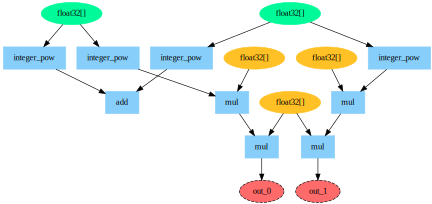

In [9]:
util.jaxpr_graph(df, 2.0, 3.0)

In [10]:
from jax.lax import stop_gradient


def f(x, y):
    return x**2 + stop_gradient(y**2)


df = grad(f, argnums=(0, 1), has_aux=False)

f(2.0, 3.0), df(2.0, 3.0)

(13.0,
 (Array(4., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True)))

In [11]:
make_jaxpr(df)(2.0, 3.0)

{ lambda ; a:f32[] b:f32[]. let
    c:f32[] = integer_pow[y=2] a
    d:f32[] = integer_pow[y=1] a
    e:f32[] = mul 2.0 d
    f:f32[] = integer_pow[y=2] b
    g:f32[] = integer_pow[y=1] b
    _:f32[] = mul 2.0 g
    h:f32[] = stop_gradient f
    _:f32[] = add c h
    i:f32[] = mul 1.0 e
  in (i, 0.0) }

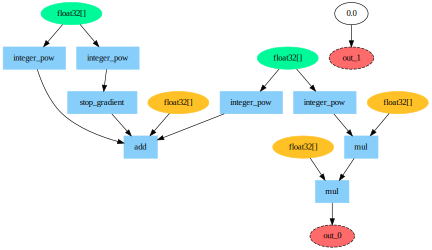

In [12]:
util.jaxpr_graph(df, 2.0, 3.0)

# Operators

## Broadcast_in_dim

In [20]:
import jax
import jax.numpy as jnp

In [22]:
input_array = jnp.arange(4)
input_array

Array([0, 1, 2, 3], dtype=int32)

In [24]:
out = jax.lax.broadcast_in_dim(operand=input_array,shape=(2,3,4),broadcast_dimensions=(2,))
out
# here shape is target shape 
# broadcast_dimensions --> dimension which match the input shape and target shape
# input shape -- > (4,)
# target_shape --> (2,3,4)
# at 2 dimension of target shape match input shape

Array([[[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]],

       [[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]]], dtype=int32)

In [25]:
input_array = jnp.arange(6).reshape(2,3)
input_array

Array([[0, 1, 2],
       [3, 4, 5]], dtype=int32)

In [26]:
out = jax.lax.broadcast_in_dim(operand=input_array,shape=(2,3,4),broadcast_dimensions=(0,1,))
out
# here shape is target shape 
# broadcast_dimensions --> dimension which match the input shape and target shape
# input shape -- > (2,3,)
# target_shape --> (2,3,4)
# at (0,1) dimension of target shape match input shape

Array([[[0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2]],

       [[3, 3, 3, 3],
        [4, 4, 4, 4],
        [5, 5, 5, 5]]], dtype=int32)

In [28]:
out = jax.lax.broadcast_in_dim(operand=input_array,shape=(2,4,3),broadcast_dimensions=(0,2,))
out
# here shape is target shape 
# broadcast_dimensions --> dimension which match the input shape and target shape
# input shape -- > (2,3,)
# target_shape --> (2,4,3)
# at (0,2) dimension of target shape match input shape

Array([[[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]],

       [[3, 4, 5],
        [3, 4, 5],
        [3, 4, 5],
        [3, 4, 5]]], dtype=int32)

# broadcasted_iota

increment along specified dimension.

In [3]:
import jax
import jax.numpy as jnp

In [22]:
jax.lax.broadcasted_iota(dtype=jnp.int32,shape=(2,3,4),dimension=0)

Array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]]], dtype=int32)

In [25]:
jax.lax.broadcasted_iota(dtype=jnp.int32,shape=(2,3,4),dimension=1)

Array([[[0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2]],

       [[0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2]]], dtype=int32)

In [26]:
jax.lax.broadcasted_iota(dtype=jnp.int32,shape=(2,3,4),dimension=2)

Array([[[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]],

       [[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]]], dtype=int32)

In [31]:
jnp.arange(24).reshape(2,3,4)

Array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]], dtype=int32)